In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
from functools import partial
import optuna

In [8]:
data = pd.read_csv('data/train.csv')
data.head()

dist                      due   f_class        lat        lon  \
0   5117.239228  2014-01-22 04:10:00.000    econom  55.669290  37.474336   
1   3638.726690  2014-01-10 13:45:00.000    econom  55.807461  37.635045   
2  15143.069693  2014-03-02 02:10:00.000    econom  55.741105  37.615821   
3     -1.000000  2014-02-26 13:20:00.000    econom  55.625526  37.618543   
4   4708.142572  2014-01-21 19:45:00.000  business  55.813167  37.597863   

    s_class t_class  target  
0  business     NaN       0  
1  business     NaN       0  
2       NaN     NaN       1  
3       NaN     NaN       1  
4       NaN     NaN       0

In [9]:
data['target']\
    .value_counts()\
    .to_frame()\
    .reset_index()\
    .set_axis(['target', 'counts'], axis=1)

target   counts
0       0  1016036
1       1   171425

# Explore features

## Dist

Distance `-1` probably means unpecified end point 

In [10]:
data.loc[data['dist'] < 0, 'dist'] = np.nan
data['location_unspecified'] = data['dist'].isna()

In [11]:
dist_threshold = data['dist'].quantile(0.99)

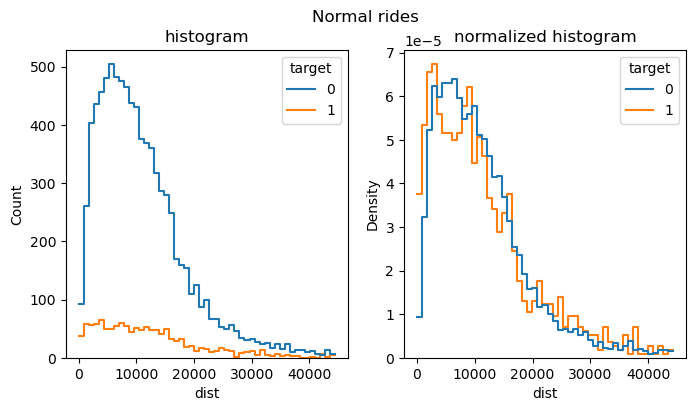

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

fig.suptitle('Normal rides')
axes[0].set_title('histogram')
sns.histplot(
    data.query('dist < @dist_threshold').sample(10_000), 
    x='dist', 
    hue='target',
    fill=False,
    element='step',
    ax=axes[0]
)

axes[1].set_title('normalized histogram')
sns.histplot(
    data.query('dist < @dist_threshold').sample(10_000), 
    x='dist', 
    hue='target',
    fill=False,
    element='step',
    stat='density',
    common_norm=False,
    ax=axes[1]
)

plt.show()

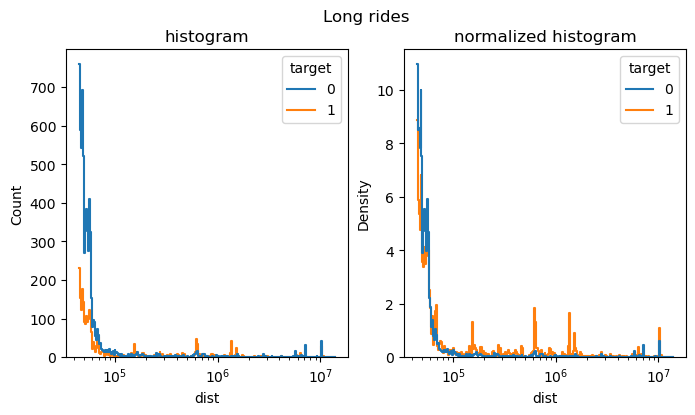

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

fig.suptitle('Long rides')
axes[0].set_title('histogram')
sns.histplot(
    data.query('dist > @dist_threshold'), 
    x='dist', 
    hue='target',
    fill=False,
    element='step',
    log_scale=True,
    ax=axes[0],
)

axes[1].set_title('normalized histogram')
sns.histplot(
    data.query('dist > @dist_threshold'), 
    x='dist', 
    hue='target',
    fill=False,
    element='step',
    stat='density',
    common_norm=False,
    log_scale=True,
    ax=axes[1]
)

plt.show()

In [14]:
data\
    .groupby(['location_unspecified', 'target'])\
    .size()\
    .reset_index()\
    .pivot(index='location_unspecified', columns='target', values=0) / len(data)

target                       0         1
location_unspecified                    
False                 0.779909  0.115809
True                  0.075728  0.028553

## due

In [15]:
data['due'] = pd.to_datetime(data['due'])

In [16]:
data['year'] = data['due'].dt.year
data['month'] = data['due'].dt.month
data['day'] = data['due'].dt.day
data['hour'] = data['due'].dt.hour
data['weekday'] = data['due'].dt.weekday

### year

In [17]:
data['year'].value_counts()

2014    1187461
Name: year, dtype: int64

In [18]:
data.drop('year', axis=1, inplace=True)

### month

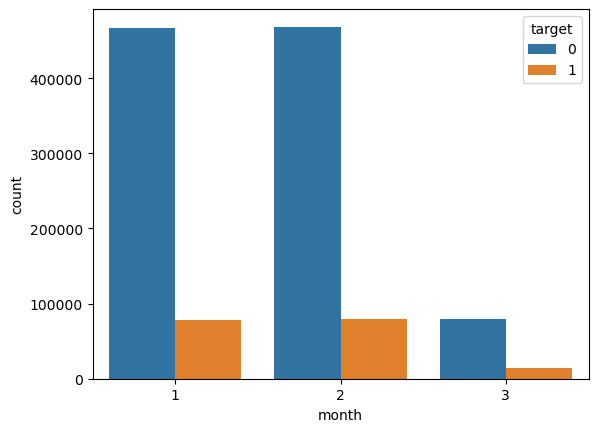

In [19]:
sns.countplot(
    data=data,
    x='month',
    hue='target'
)

plt.show()

тоже лажа

In [20]:
data.drop('month', axis=1, inplace=True)

### weekday

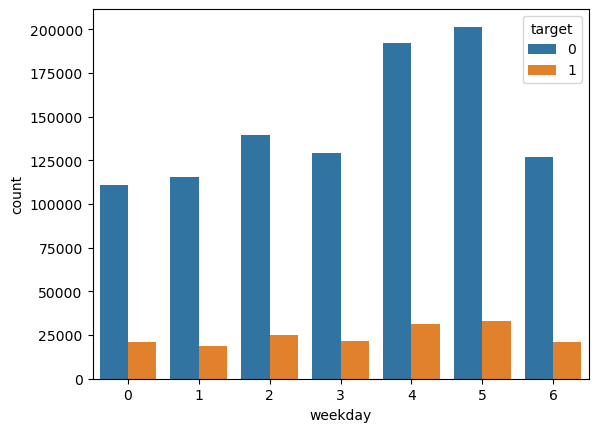

In [21]:
sns.countplot(
    data=data,
    x='weekday',
    hue='target'
)

plt.show()

### hour

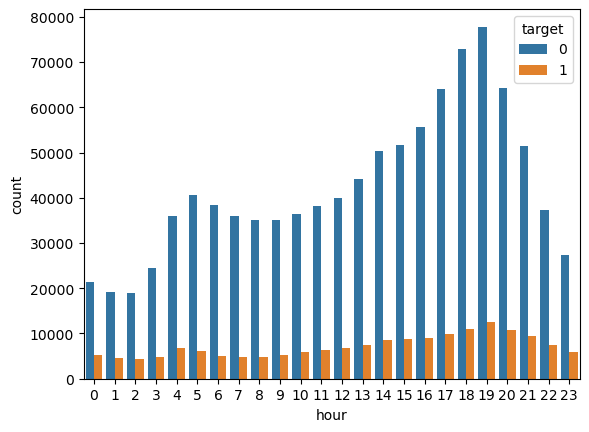

In [22]:
sns.countplot(
    data=data,
    x='hour',
    hue='target'
)

plt.show()

## *_class

In [23]:
data['f_class'].unique()

array(['econom', 'business', 'vip', nan], dtype=object)

In [24]:
data['s_class'].unique()

array(['business', nan, 'vip', 'econom'], dtype=object)

In [25]:
data['t_class'].unique()

array([nan, 'vip', 'econom', 'business'], dtype=object)

In [26]:
data[['f_class', 's_class', 't_class', 'target']]\
    .astype(str)\
    .value_counts().\
    reset_index().\
    rename(columns={0: 'counts'})

f_class   s_class   t_class target  counts
0     econom       nan       nan      0  586571
1     econom  business       nan      0  250039
2   business       nan       nan      0  112516
3     econom       nan       nan      1   93788
4     econom  business       nan      1   45004
5   business       vip       nan      0   23639
6   business       nan       nan      1   16798
7        vip       nan       nan      0   13530
8     econom  business       vip      0   13181
9        nan       nan       nan      0    9505
10  business    econom       nan      0    4554
11  business       vip       nan      1    4549
12    econom  business       vip      1    3567
13       vip       nan       nan      1    3427
14       nan       nan       nan      1    2406
15       vip  business       nan      0    1339
16  business    econom       nan      1    1021
17       vip  business       nan      1     362
18       vip  business    econom      0     287
19  business       vip    econom      0     275
20    econom       vip  business      0     239
21       vip    econom  business      0     170
22  business    econom       vip      0     170
23       vip  business    econom      1     139
24    econom       vip  business      1     120
25  business       vip    econom      1      89
26  business    econom       vip      1      78
27       vip    econom  business      1      73
28    econom       vip       nan      0      21
29    econom       vip       nan      1       4

In [27]:
data['multi_class'] = \
    data['f_class'].astype(str) + '_' + \
    data['s_class'].astype(str) + '_' + \
    data['s_class'].astype(str)

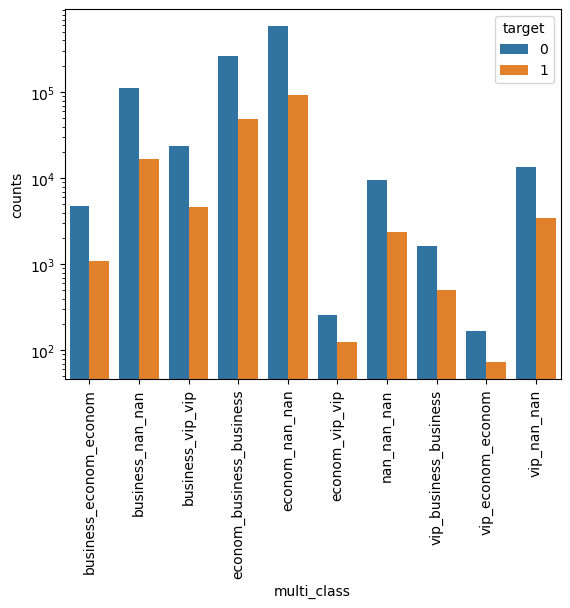

In [28]:
sns.barplot(
    data=data\
        .groupby(['multi_class', 'target'])\
        .size()\
        .reset_index()\
        .rename(columns={0: 'counts'}),
    x='multi_class',
    y='counts',
    hue='target',
)

plt.yscale('log')
plt.xticks(rotation=90)
plt.show()

Надо заметить, что в данном случае мы хотим найти группы где вероятность отмены больше чем в других.  
В лог шкале отношение колечества это разность между столбиками и именно это надо сранивать в разных группах.

## location

In [29]:
import folium

In [30]:
data.loc[data['lat'] < 1, 'lat'] = np.nan
data.loc[data['lon'] < 1, 'lat'] = np.nan

In [31]:
data['location_nan'] = data['lat'].isna() | data['lon'].isna()

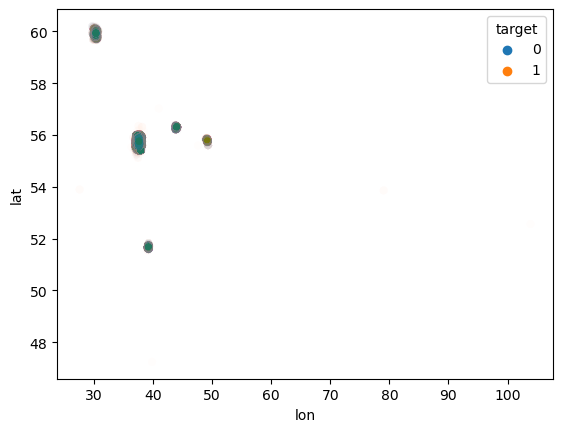

In [32]:
sns.scatterplot(data=data, x='lon', y='lat', hue='target', alpha=0.01)
plt.show()

In [33]:
# Ставим лайк https://www.kaggle.com/code/egorborodin/add-map/notebook
size = 5000
get_map = folium.Map(location=(55.7, 37.6))

for _, row in data.sample(size).iterrows():
    folium.Circle(
        (row['lat'], row['lon']),
        color='red' if row['target'] else 'green',
        fill=True, 
        radius=3
    ).add_to(get_map)
    
get_map

In [34]:
from sklearn.metrics.pairwise import haversine_distances

In [35]:
actual_cities = [
    'Moscow', 
    'Saint Petersburg', 
    'Voronezh', 
    'Kazan', 
    'Nizhniy Novgorod'
]

cities_df = pd.read_csv('data/worldcities.csv').rename(columns={'lng': 'lon'})
cities_df = cities_df[cities_df['city'].isin(actual_cities)]
cities_df.head()

city        city_ascii      lat      lon country iso2 iso3  \
17             Moscow            Moscow  55.7558  37.6178  Russia   RU  RUS   
123  Saint Petersburg  Saint Petersburg  59.9500  30.3167  Russia   RU  RUS   
606  Nizhniy Novgorod  Nizhniy Novgorod  56.3269  44.0075  Russia   RU  RUS   
615             Kazan             Kazan  55.7964  49.1089  Russia   RU  RUS   
728          Voronezh          Voronezh  51.6717  39.2106  Russia   RU  RUS   

                  admin_name  capital  population          id  
17                    Moskva  primary  17332000.0  1643318494  
123          Sankt-Peterburg    admin   5384342.0  1643616350  
606  Nizhegorodskaya Oblast’    admin   1264075.0  1643012126  
615                Tatarstan    admin   1243500.0  1643101260  
728    Voronezhskaya Oblast’    admin   1050602.0  1643811064

In [36]:
# Ставим лайк https://www.kaggle.com/code/eugene556/nearest-big-city-to-point-using-other-dataset
X_train_pos = np.deg2rad(data[['lat', 'lon']].fillna(-1))
cities_pos = np.deg2rad(cities_df[['lat', 'lon']])

X_train_dists = haversine_distances(X_train_pos, cities_pos) * 6371000/1000
data['city'] = cities_df['city'].iloc[np.argmin(X_train_dists, axis=1).ravel()].values
data['city_dist'] = np.min(X_train_dists, axis=1)

data.loc[data[['lat', 'lon']].isna().any(axis=1), ['city', 'city_dist']] = np.nan

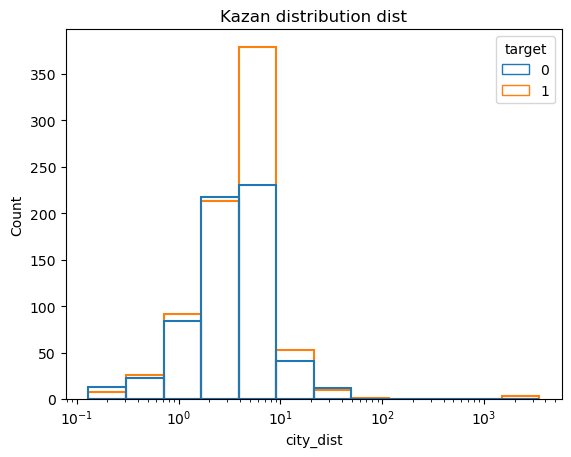

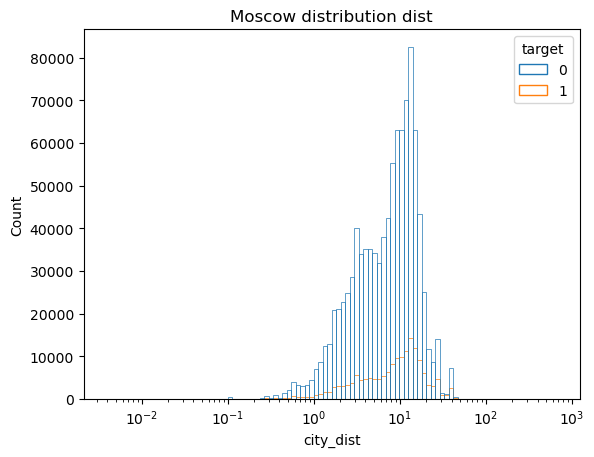

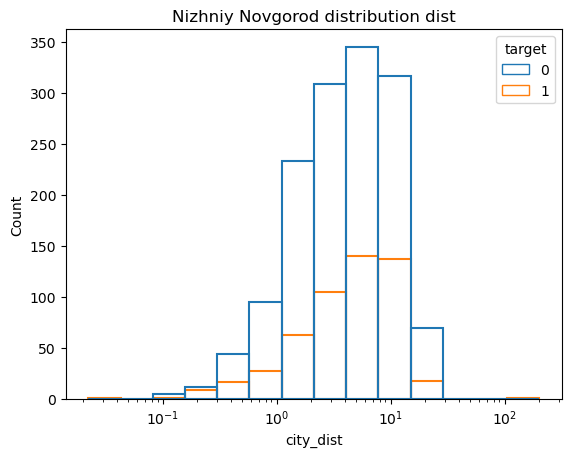

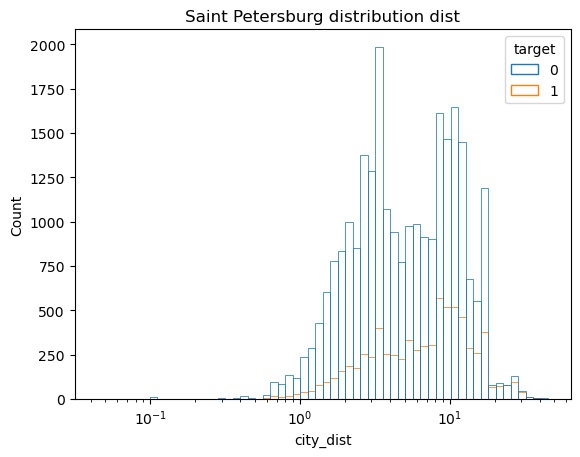

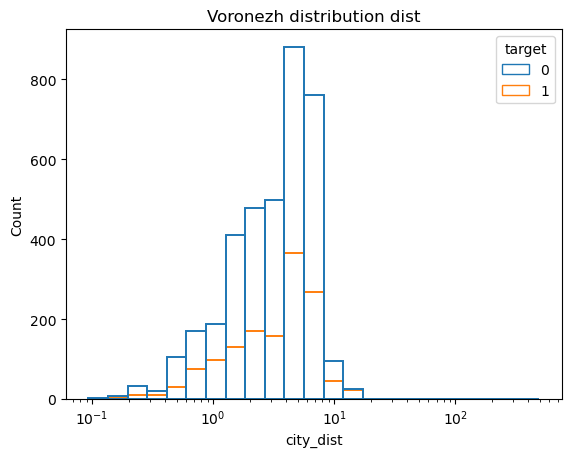

In [37]:
for city, df in data.groupby('city'):
    plt.title(f'{city} distribution dist')
    sns.histplot(
        data=df, 
        x='city_dist', 
        log_scale=True,
        fill=False,
        hue='target',
        bins=min(int(np.sqrt(len(df)) / 3), 100)
    )
    plt.show()

Не совсем понятно насколько полезный признак, потому что внутри города это линейное преобразование  
Больше признаков, не меньше так что пусть будет

In [38]:
city_dist_std = data\
    .groupby('city')['city_dist']\
    .std()\
    .reset_index()\
    .set_axis(['city', 'city_dist_std'], axis=1)

data = data.merge(city_dist_std, on='city', how='left')
data['city_dist_normed'] = data['city_dist'] / data['city_dist_std']

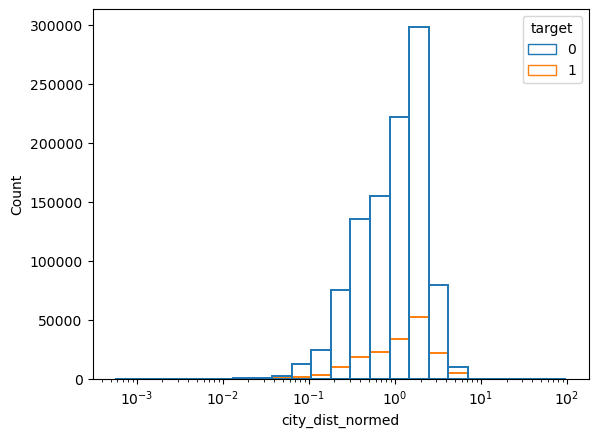

In [39]:
sns.histplot(
    data=data, 
    x='city_dist_normed', 
    log_scale=True,
    fill=False,
    hue='target',
    bins=min(int(np.sqrt(len(df)) / 3), 100)
)
plt.show()

Прорабатываем сценарий что кто то заказал такси, отменил и заказал новое

In [40]:
data[['lat', 'lon']].value_counts().reset_index().rename(columns={0: 'counts'})

lat        lon  counts
0       55.414327  37.900470    5215
1       55.962873  37.405977    3206
2       55.963949  37.416889    2233
3       55.776507  37.581550    2139
4       55.776882  37.654808    2004
...           ...        ...     ...
292234  55.735103  37.524153       1
292235  55.735103  37.713205       1
292236  55.735103  37.675785       1
292237  55.735104  37.586417       1
292238  60.209064  29.847831       1

[292239 rows x 3 columns]

In [41]:
data.sort_values(by='due', inplace=True)
data['diff_time_loc'] = data.groupby(['lat', 'lon'])['due'].diff().dt.seconds

In [42]:
data['no_prev_loc'] = data['diff_time_loc'].isna()

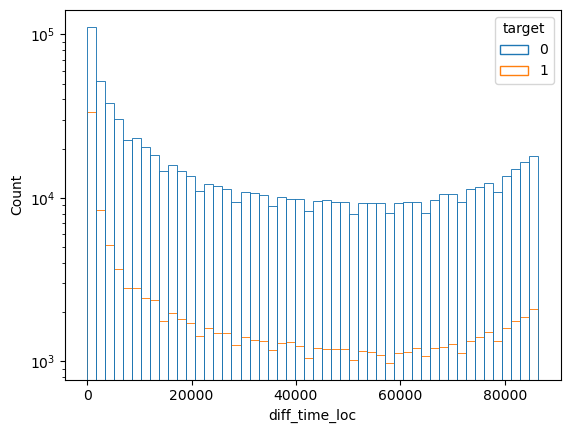

In [43]:
sns.histplot(
    data=data, 
    x='diff_time_loc', 
    hue='target',
    fill=False,
    bins=50,
)
plt.yscale('log')
plt.show()

Выглядит неплохо, маленькие значения кажется повышают вероятность отмены.  
Попробуем чуть смазать местоположения и добавить значения после

In [44]:
rounds = [2, 3, 4, 6]
periods = [1, 3, 5, 10]

In [45]:
for round, period in product(rounds, periods):
    data[[f'lat_round_{round}', f'lon_round_{round}']] = data[['lat', 'lon']].round(round)
    data[f'diff_time_prev_{round}_{period}'] = data\
        .groupby([f'lat_round_{round}', f'lon_round_{round}'])['due']\
        .diff(periods=period).dt.seconds
    
    data[f'diff_time_post_{round}_{period}'] = data\
        .groupby([f'lat_round_{round}', f'lon_round_{round}'])['due']\
        .diff(periods=-period).dt.seconds
    
    data[f'diff_time_{round}_{period}'] = data[[f'diff_time_prev_{round}_{period}', f'diff_time_post_{round}_{period}']].min(axis=1)

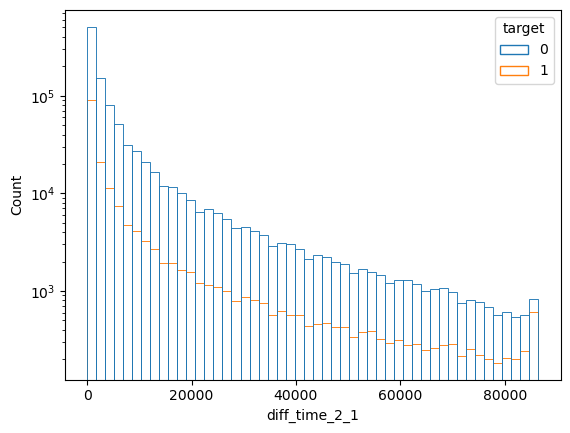

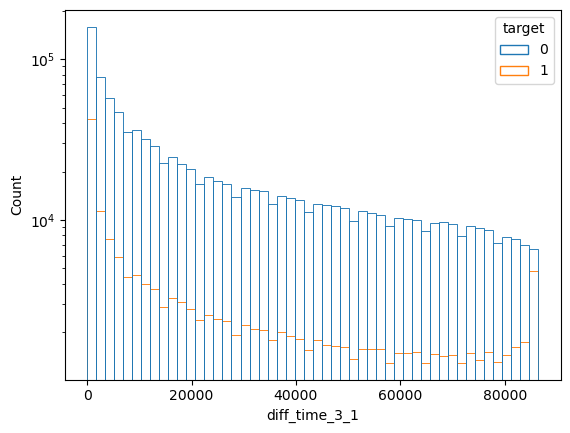

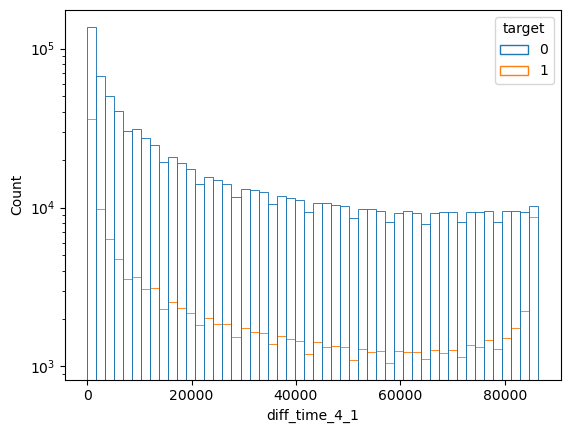

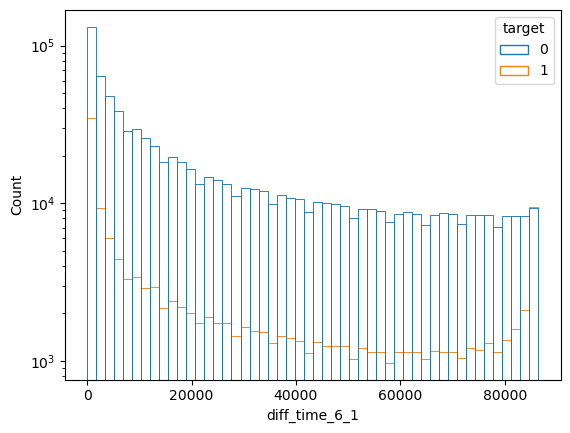

In [46]:
for i in rounds:
    sns.histplot(
        data=data, 
        x=f'diff_time_{i}_1', 
        hue='target',
        fill=False,
        bins=50,
    )
    plt.yscale('log')
    plt.show()

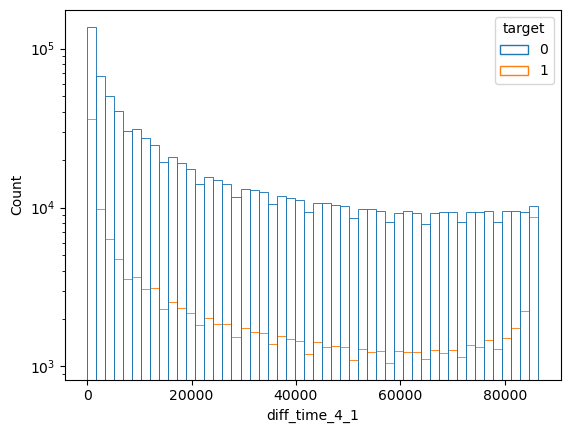

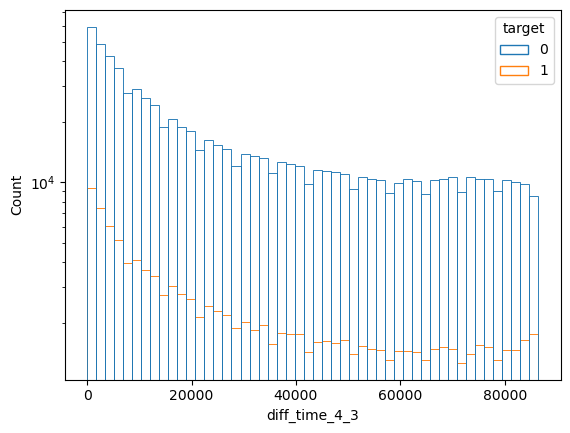

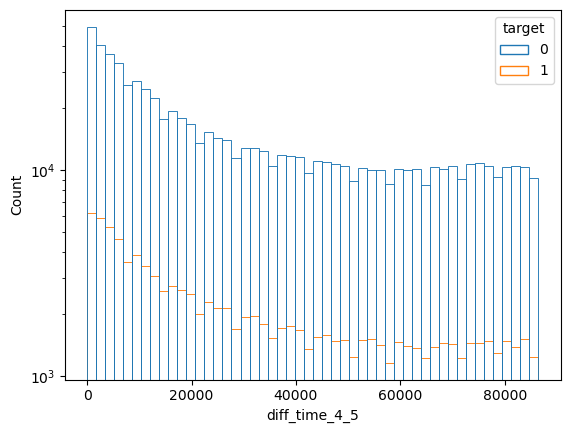

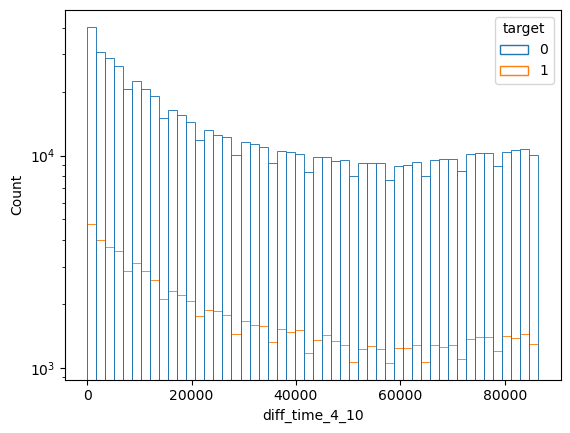

In [47]:
for i in periods:
    sns.histplot(
        data=data, 
        x=f'diff_time_4_{i}', 
        hue='target',
        fill=False,
        bins=50,
    )
    plt.yscale('log')
    plt.show()

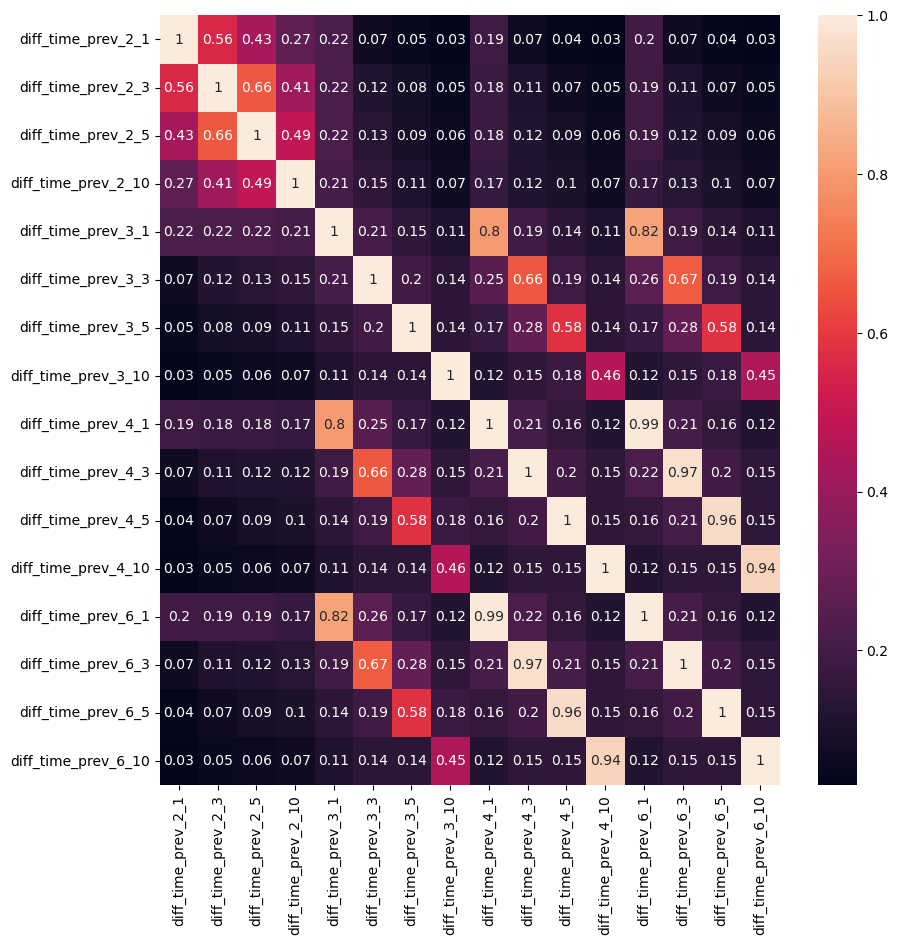

In [48]:
diff_time_columns = [f'diff_time_prev_{round}_{period}' for round, period in product(rounds, periods)]
corr_df = data[diff_time_columns].corr().round(2)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, annot=True)
plt.show()

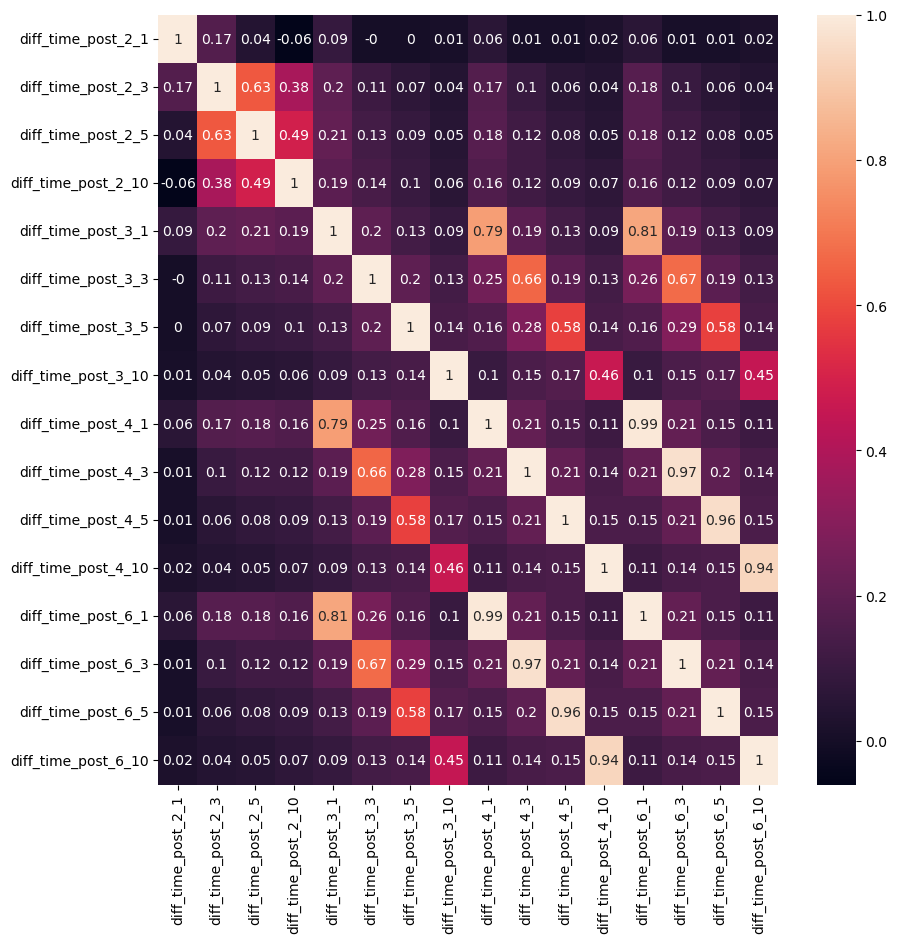

In [49]:
diff_time_columns = [f'diff_time_post_{round}_{period}' for round, period in product(rounds, periods)]
corr_df = data[diff_time_columns].corr().round(2)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, annot=True)
plt.show()

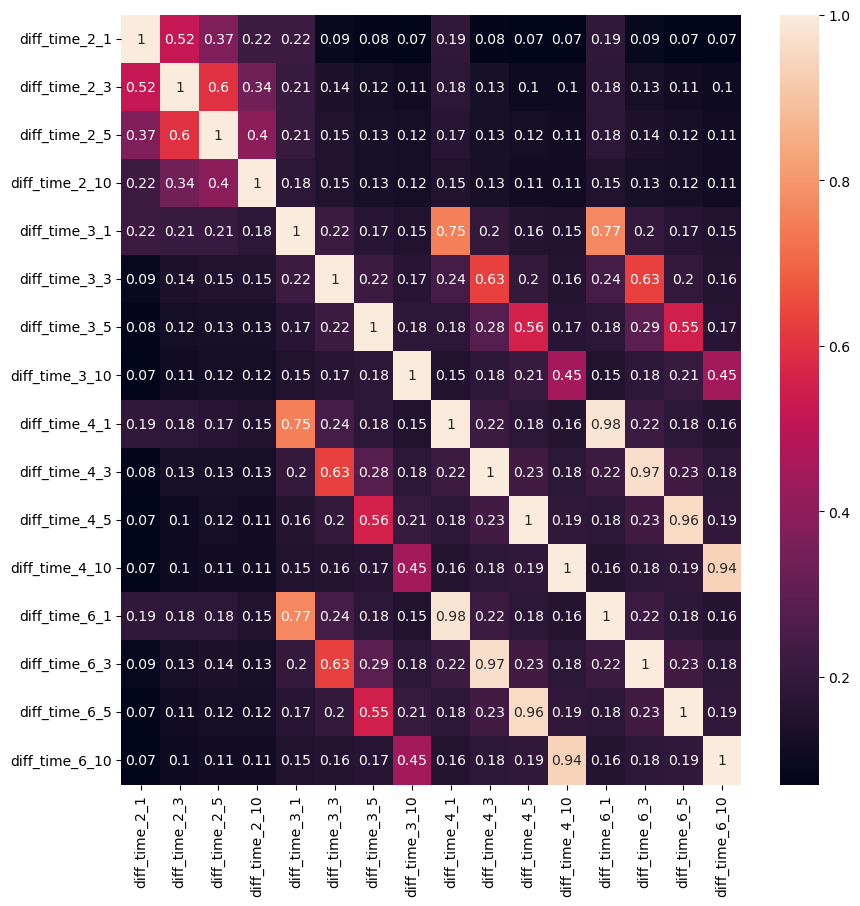

In [50]:
diff_time_columns = [f'diff_time_{round}_{period}' for round, period in product(rounds, periods)]
corr_df = data[diff_time_columns].corr().round(2)

plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, annot=True)
plt.show()

# Get districts

In [51]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [52]:
cluster = GaussianMixture(n_components=20)
# cluster = KMeans(n_clusters=20)
cluster.fit(data[['lon', 'lat']].fillna(-1))

GaussianMixture(n_components=20)

In [53]:
k_best_district = 3
data[[f'district_{i + 1}' for i in range(k_best_district)]] = cluster\
    .predict_proba(data[['lon', 'lat']].fillna(-1))\
    .argsort(axis=1)[:, -k_best_district:]

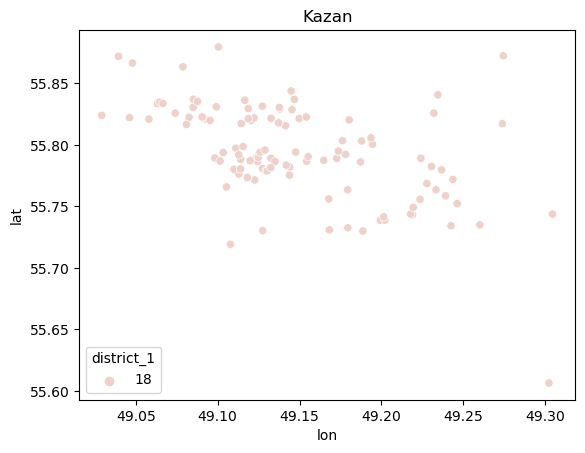

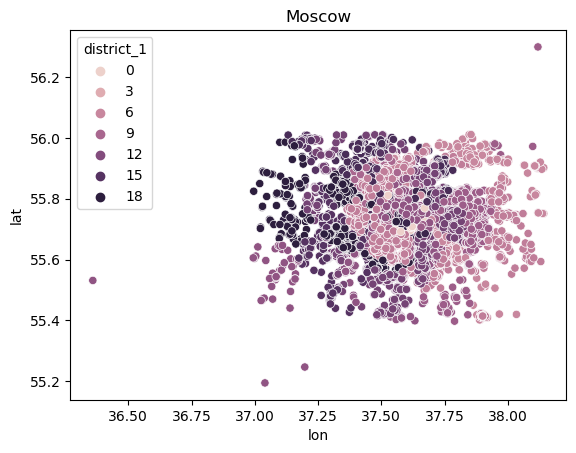

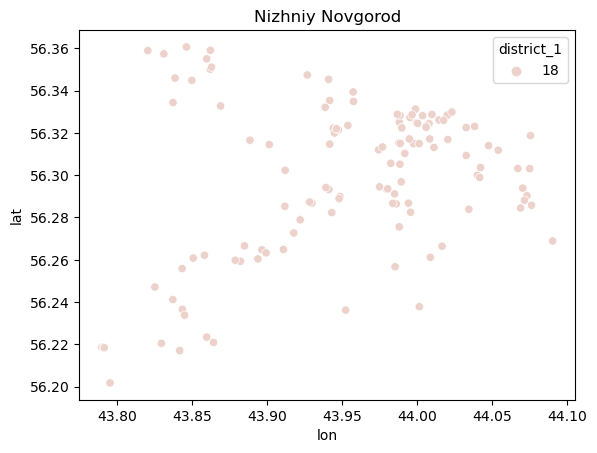

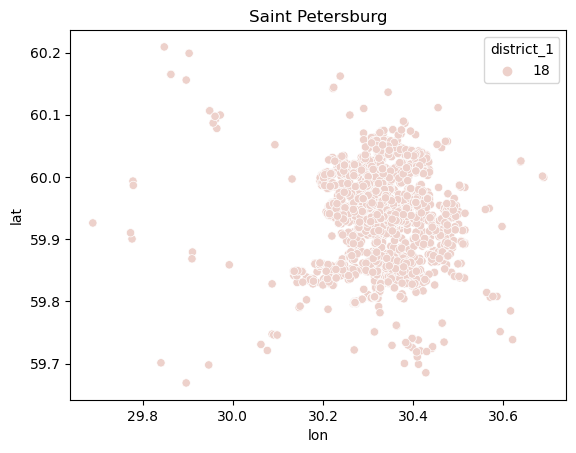

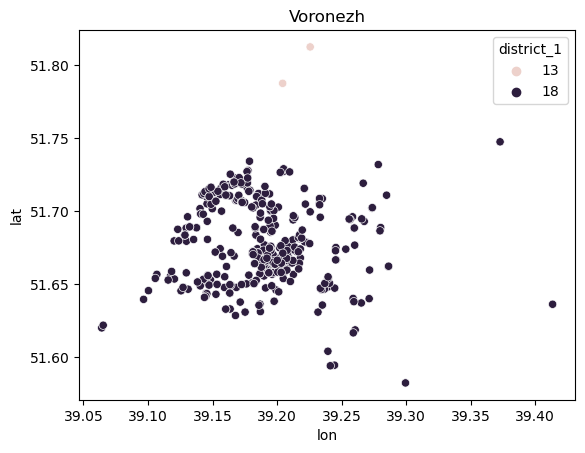

In [54]:
for city, df in data.sample(100_000).groupby('city'):
    plt.title(city)
    with sns.color_palette('bright'):
        sns.scatterplot(data=df, x='lon', y='lat', hue='district_1')
    plt.show()

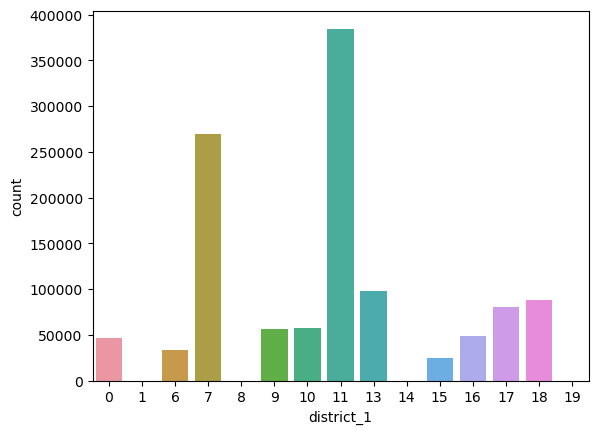

In [55]:
sns.countplot(data=data, x='district_1')
plt.show()

In [56]:
def create_cluster_df(cluster):
    df = {}
    
    n_comp = cluster.n_components
    df['district'] = np.arange(n_comp)
    
    df['district_lon'] = cluster.means_[:, 0]
    df['district_lat'] = cluster.means_[:, 1]
    df['district_weight'] = cluster.weights_

    return pd.DataFrame(df)

In [57]:
cluster_df = create_cluster_df(cluster)
cluster_df

district  district_lon  district_lat  district_weight
0          0     37.591687     55.762712     1.993018e-01
1          1     30.332329     59.938029     2.295650e-02
2          2     49.141371     55.794137     1.180670e-03
3          3     39.190017     51.677762     4.264561e-03
4          4     43.957373     56.301652     1.640475e-03
5          5      0.000000     -1.000000     6.737063e-06
6          6     37.764829     55.774083     5.966632e-02
7          7     37.415610     55.713807     4.070920e-02
8          8    103.875951     52.562230     8.421329e-07
9          9     37.507016     55.802376     8.504535e-02
10        10     37.728641     55.664118     4.913687e-02
11        11     37.579766     55.684984     1.331167e-01
12        12     79.027275     53.859860     1.684266e-06
13        13     37.792341     55.749988     2.607212e-02
14        14     37.899522     55.414496     7.456621e-03
15        15     37.412741     55.841268     5.191634e-02
16        16     37.606873     55.856561     6.453136e-02
17        17     37.645018     55.753518     1.392198e-01
18        18     37.487574     55.696795     1.089918e-01
19        19     30.305999     59.885001     4.784201e-03

In [58]:
for i in range(1, k_best_district + 1):
    data = data.merge(cluster_df.add_suffix(f'_{i}'), on=f'district_{i}', how='left')
data.head()

dist                 due f_class        lat        lon s_class  \
0  17990.125431 2014-01-01 00:09:32  econom  55.750130  37.823242     NaN   
1   2322.180999 2014-01-01 00:10:00  econom  55.711488  37.884183     NaN   
2  14608.577392 2014-01-01 00:10:00  econom  55.633404  37.797595     NaN   
3  20055.569096 2014-01-01 00:10:00  econom  55.780380  37.645240     NaN   
4  20585.444093 2014-01-01 00:10:00  econom  55.675676  37.500387     NaN   

  t_class  target  location_unspecified  day  ...  district_3  district_lon_1  \
0     NaN       1                 False    1  ...           6       37.728641   
1     NaN       0                 False    1  ...           6       37.728641   
2     NaN       0                 False    1  ...          10       37.764829   
3     NaN       0                 False    1  ...          17       37.579766   
4     NaN       1                 False    1  ...          18       37.415610   

  district_lat_1  district_weight_1 district_lon_2  district_lat_2  \
0      55.664118           0.049137      37.792341       55.749988   
1      55.664118           0.049137      37.792341       55.749988   
2      55.774083           0.059666      37.792341       55.749988   
3      55.684984           0.133117      37.591687       55.762712   
4      55.713807           0.040709      37.579766       55.684984   

   district_weight_2  district_lon_3  district_lat_3  district_weight_3  
0           0.026072       37.764829       55.774083           0.059666  
1           0.026072       37.764829       55.774083           0.059666  
2           0.026072       37.728641       55.664118           0.049137  
3           0.199302       37.645018       55.753518           0.139220  
4           0.133117       37.487574       55.696795           0.108992  

[5 rows x 88 columns]

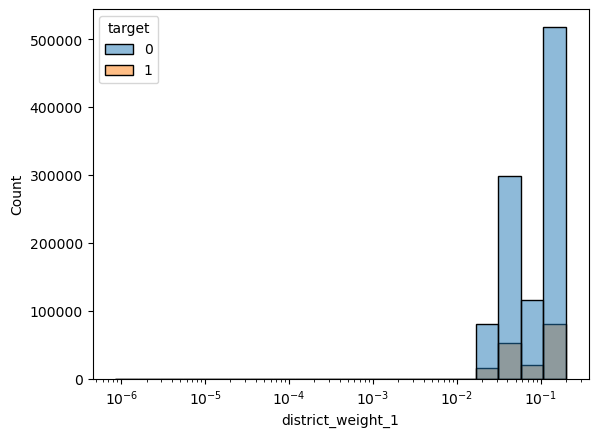

In [59]:
sns.histplot(data=data, x='district_weight_1', hue='target', log_scale=True, bins=20)
plt.show()

In [60]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [61]:
for i in range(1, k_best_district + 1):
    data[f'district_dist_{i}'] = haversine_np(data['lon'], data['lat'], data[f'district_lon_{i}'], data[f'district_lat_{i}'])

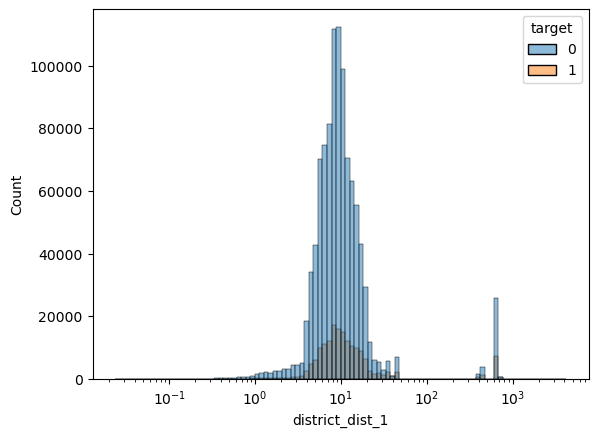

In [62]:
sns.histplot(data=data, x='district_dist_1', hue='target', log_scale=True, bins=100)
plt.show()

Что-то дистрикт не очень радует

# Outliers

In [63]:
from sklearn.ensemble import IsolationForest

In [64]:
clf = IsolationForest()
clf.fit(data[['lat', 'lon']].fillna(-1))

IsolationForest()

In [65]:
data['loc_isolation_score'] = -clf.score_samples(data[['lat', 'lon']].fillna(-1))

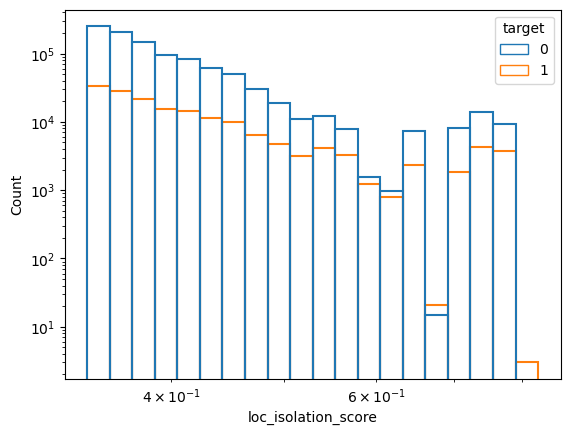

In [66]:
sns.histplot(
    data=data,
    x='loc_isolation_score',
    hue='target',
    log_scale=True,
    bins=20,
    fill=False
)
plt.yscale('log')
plt.show()

Неплохо, некоторые значения свидетельствуют о высокой вероятности отмены 

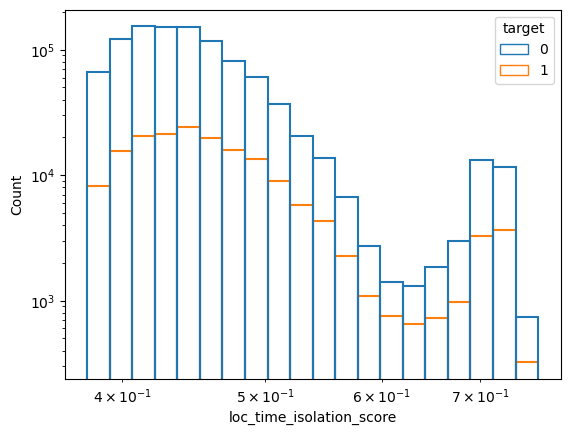

In [67]:
clf = IsolationForest()
clf.fit(data[['lat', 'lon', 'hour', 'weekday']].fillna(-1))
data['loc_time_isolation_score'] = -clf.score_samples(data[['lat', 'lon', 'hour', 'weekday']].fillna(-1))
sns.histplot(
    data=data,
    x='loc_time_isolation_score',
    hue='target',
    log_scale=True,
    bins=20,
    fill=False
)
plt.yscale('log')
plt.show()

Тоже интересно

# Load Data from scratch and train test split

In [68]:
train_data = pd.read_csv('data/train.csv')
predict_data = pd.read_csv('data/test.csv')

In [69]:
actual_cities = [
    'Moscow', 
    'Saint Petersburg', 
    'Voronezh', 
    'Kazan', 
    'Nizhniy Novgorod'
]

cities_df = pd.read_csv('data/worldcities.csv').rename(columns={'lng': 'lon'})
cities_df = cities_df[cities_df['city'].isin(actual_cities)]
cities_df.head()

city        city_ascii      lat      lon country iso2 iso3  \
17             Moscow            Moscow  55.7558  37.6178  Russia   RU  RUS   
123  Saint Petersburg  Saint Petersburg  59.9500  30.3167  Russia   RU  RUS   
606  Nizhniy Novgorod  Nizhniy Novgorod  56.3269  44.0075  Russia   RU  RUS   
615             Kazan             Kazan  55.7964  49.1089  Russia   RU  RUS   
728          Voronezh          Voronezh  51.6717  39.2106  Russia   RU  RUS   

                  admin_name  capital  population          id  
17                    Moskva  primary  17332000.0  1643318494  
123          Sankt-Peterburg    admin   5384342.0  1643616350  
606  Nizhegorodskaya Oblast’    admin   1264075.0  1643012126  
615                Tatarstan    admin   1243500.0  1643101260  
728    Voronezhskaya Oblast’    admin   1050602.0  1643811064

In [70]:
train_data.sort_values(by='due', inplace=True)
train_size = int(len(train_data) * 0.7)
train_df = train_data.iloc[:train_size, :]
test_df = train_data.iloc[train_size:, :]

# Transformer

In [71]:
class MyTransformer:
    def __init__(self, cities_df, loc_rounds, loc_periods, n_districts, k_best_district):
        self.cities_df = cities_df.copy()
        self.loc_rounds = loc_rounds.copy()
        self.loc_periods = loc_periods.copy()
        self.n_districts = n_districts
        self.cluster = GaussianMixture(n_components=n_districts)
        self.k_best_clusters = k_best_district

    def fit(self, df):
        self.fit_transform(df)

    def fit_transform(self, df):
        df = df.copy()
        self.city_dist_std = None
        self.cluster.fit(df[['lon', 'lat']].fillna(-1))
        self.cluster_df = create_cluster_df(self.cluster)

        df['due'] = pd.to_datetime(df['due'])
        df['hour'] = df['due'].dt.hour
        df['weekday'] = df['due'].dt.weekday
        
        self.loc_isol = IsolationForest()
        self.loc_isol.fit(data[['lat', 'lon']].fillna(-1))

        self.loc_time_isol = IsolationForest()
        self.loc_time_isol.fit(data[['lat', 'lon', 'weekday', 'hour']].fillna(-1))

        df = self.transform(df)
        
        return df

    def transform(self, df):
        df = df.copy()
        # index
        df['index'] = df.index

        # dist
        df.loc[df['dist'] < 0, 'dist'] = np.nan
        df['dist_nan'] = df['dist'].isna()

        # due
        df['due'] = pd.to_datetime(df['due'])
        df['hour'] = df['due'].dt.hour
        df['weekday'] = df['due'].dt.weekday

        # *_class
        df['multi_class'] = \
            df['f_class'].astype(str) + '_' + \
            df['s_class'].astype(str) + '_' + \
            df['t_class'].astype(str)

        # lat lon
        df['location_nan'] = df['lat'].isna() | df['lon'].isna()

        # cities
        X_train_pos = np.deg2rad(df[['lat', 'lon']].fillna(-1))
        cities_pos = np.deg2rad(self.cities_df[['lat', 'lon']])

        X_train_dists = haversine_distances(X_train_pos, cities_pos) * 6371000/1000
        df['city'] = cities_df['city'].iloc[np.argmin(X_train_dists, axis=1).ravel()].values
        df['city_dist'] = np.min(X_train_dists, axis=1)

        df.loc[df[['lat', 'lon']].isna().any(axis=1), ['city', 'city_dist']] = np.nan

        if self.city_dist_std is None:
            self.city_dist_std = df\
                .groupby('city')['city_dist']\
                .std()\
                .reset_index()\
                .set_axis(['city', 'city_dist_std'], axis=1)

        df = df.merge(self.city_dist_std, on='city', how='left')
        df['city_dist_normed'] = df['city_dist'] / df['city_dist_std']

        # diff time same loc
        df.sort_values(by='due', inplace=True)
        for round, period in product(self.loc_rounds, self.loc_periods):
            df[[f'lat_round_{round}', f'lon_round_{round}']] = df[['lat', 'lon']].round(round)
            df[f'diff_time_prev_{round}_{period}'] = df\
                .groupby([f'lat_round_{round}', f'lon_round_{round}'])['due']\
                .diff(periods=period).dt.seconds
            
            df[f'diff_time_post_{round}_{period}'] = df\
                .groupby([f'lat_round_{round}', f'lon_round_{round}'])['due']\
                .diff(periods=-period).dt.seconds
            
            df[f'diff_time_{round}_{period}'] = df[[f'diff_time_prev_{round}_{period}', f'diff_time_post_{round}_{period}']].min(axis=1)

        # district
        df[[f'district_{i + 1}' for i in range(self.k_best_clusters)]] = self.cluster\
            .predict_proba(df[['lon', 'lat']].fillna(-1))\
            .argsort(axis=1)[:, -k_best_district:]

        for i in range(1, self.k_best_clusters + 1):
            df = df.merge(self.cluster_df.add_suffix(f'_{i}'), on=f'district_{i}', how='left')

        for i in range(1, self.k_best_clusters + 1):
            df[f'district_dist_{i}'] = haversine_np(df['lon'], df['lat'], df[f'district_lon_{i}'], df[f'district_lat_{i}'])

        df.sort_values(by='due', inplace=True)
        df['diff_time_district_prev'] = df.groupby('district_1')['due'].diff(periods=1).dt.seconds
        df['diff_time_district_post'] = df.groupby('district_1')['due'].diff(periods=-1).dt.seconds
        df['diff_time_district'] = df[['diff_time_district_prev', 'diff_time_district_post']].min(axis=1)

        # mesure of outliers
        df['loc_isolation_score'] = -self.loc_isol.score_samples(df[['lat', 'lon']].fillna(-1))
        df['loc_time_isolation_score'] = -self.loc_time_isol.score_samples(df[['lat', 'lon', 'weekday', 'hour']].fillna(-1))

        # distance comparison
        df['dist_vs_city'] = df['dist'] - df['city_dist']
        
        for i in range(1, self.k_best_clusters + 1):
            df[f'dist_vs_district_{i}'] = df['dist'] - df[f'district_dist_{i}']

        return df


In [72]:
loc_rounds = [2, 3, 4, 6]
loc_periods = [1, 3, 5, 10]
n_districts = 20
k_best_districts = 3

In [73]:
transformer = MyTransformer(cities_df, loc_rounds, loc_periods, n_districts, k_best_districts)
train_df_trans = transformer.fit_transform(train_df)
test_df_trans = transformer.transform(test_df)

In [74]:
train_df_trans.head()

dist                 due f_class        lat        lon s_class  \
0  17990.125431 2014-01-01 00:09:32  econom  55.750130  37.823242     NaN   
1   2322.180999 2014-01-01 00:10:00  econom  55.711488  37.884183     NaN   
2  14608.577392 2014-01-01 00:10:00  econom  55.633404  37.797595     NaN   
3  20055.569096 2014-01-01 00:10:00  econom  55.780380  37.645240     NaN   
4  20585.444093 2014-01-01 00:10:00  econom  55.675676  37.500387     NaN   

  t_class  target  hour  weekday  ...  district_dist_3  \
0     NaN       1     0        2  ...         6.366298   
1     NaN       0     0        2  ...         5.573505   
2     NaN       0     0        2  ...        12.556890   
3     NaN       0     0        2  ...         2.894998   
4     NaN       1     0        2  ...         1.348250   

   diff_time_district_prev diff_time_district_post  diff_time_district  \
0                      NaN                 86372.0             86372.0   
1                     28.0                 86100.0                28.0   
2                      NaN                     0.0                 0.0   
3                      0.0                 86100.0                 0.0   
4                      NaN                     0.0                 0.0   

  loc_isolation_score  loc_time_isolation_score  dist_vs_city  \
0            0.450396                  0.536033  17977.254185   
1            0.502281                  0.563659   2304.790855   
2            0.489894                  0.563046  14590.908537   
3            0.357122                  0.501805  20052.341659   
4            0.383942                  0.525596  20573.891497   

   dist_vs_district_1  dist_vs_district_2  dist_vs_district_3  
0        17979.178247        17989.574781        17983.759132  
1         2311.832467         2310.323946         2316.607494  
2        14592.379852        14603.917202        14596.020501  
3        20050.174205        20051.730288        20052.674097  
4        20578.339852        20577.739237        20584.095843  

[5 rows x 98 columns]

In [75]:
train_df_trans.columns

Index(['dist', 'due', 'f_class', 'lat', 'lon', 's_class', 't_class', 'target',
       'hour', 'weekday', 'index', 'dist_nan', 'multi_class', 'location_nan',
       'city', 'city_dist', 'city_dist_std', 'city_dist_normed', 'lat_round_2',
       'lon_round_2', 'diff_time_prev_2_1', 'diff_time_post_2_1',
       'diff_time_2_1', 'diff_time_prev_2_3', 'diff_time_post_2_3',
       'diff_time_2_3', 'diff_time_prev_2_5', 'diff_time_post_2_5',
       'diff_time_2_5', 'diff_time_prev_2_10', 'diff_time_post_2_10',
       'diff_time_2_10', 'lat_round_3', 'lon_round_3', 'diff_time_prev_3_1',
       'diff_time_post_3_1', 'diff_time_3_1', 'diff_time_prev_3_3',
       'diff_time_post_3_3', 'diff_time_3_3', 'diff_time_prev_3_5',
       'diff_time_post_3_5', 'diff_time_3_5', 'diff_time_prev_3_10',
       'diff_time_post_3_10', 'diff_time_3_10', 'lat_round_4', 'lon_round_4',
       'diff_time_prev_4_1', 'diff_time_post_4_1', 'diff_time_4_1',
       'diff_time_prev_4_3', 'diff_time_post_4_3', 'diff_time_4

In [76]:
num_features = [
    'dist', 'lat', 'lon', 
    'city_dist', 'city_dist_normed',
    'loc_isolation_score', 'loc_time_isolation_score',
]

num_features += [f'diff_time_prev_{round}_{period}' for round, period in product(loc_rounds, loc_periods)]
num_features += [f'diff_time_post_{round}_{period}' for round, period in product(loc_rounds, loc_periods)]
num_features += [f'diff_time_{round}_{period}' for round, period in product(loc_rounds, loc_periods)]

num_features += [f'district_weight_{i + 1}' for i in range(k_best_districts)]
num_features += [f'district_dist_{i + 1}' for i in range(k_best_districts)]
num_features += ['dist_vs_city']
num_features += [f'dist_vs_district_{i + 1}' for i in range(k_best_districts)]
num_features += ['diff_time_district_prev', 'diff_time_district_post', 'diff_time_district']

cat_features = [
    'f_class', 's_class', 't_class', 
    'hour', 'weekday', 'dist_nan',
    'multi_class', 'location_nan', 'city', 
]

cat_features += [f'district_{i + 1}' for i in range(k_best_districts)]

# Catboost Model

In [77]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from catboost import CatBoostClassifier
beta = 0.2

In [78]:
X_train = train_df_trans[num_features + cat_features].copy()
X_train[cat_features] = X_train[cat_features].astype(str)
y_train = train_df_trans['target']

X_test = test_df_trans[num_features + cat_features].copy()
X_test[cat_features] = X_test[cat_features].astype(str)
y_test = test_df_trans['target']

In [79]:
model = CatBoostClassifier(cat_features=cat_features, learning_rate=0.05)
model.fit(
    X_train, 
    y_train, 
    verbose=False,
    eval_set=(X_test, y_test),
    use_best_model=True,
)

In [80]:
model.get_best_iteration()

999

In [81]:
y_pred = model.predict(X_test)
fbeta_score(y_test, y_pred, beta=beta)

0.602977298569565

In [82]:
y_pred = model.predict_proba(X_test)[:, 1]
threshold = np.arange(0.1, 1, 0.01)
scores = []

for t in threshold:
    scores.append(fbeta_score(y_test, y_pred > t, beta=beta))

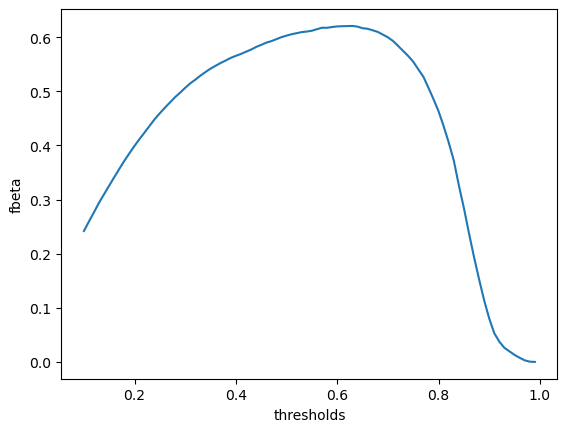

In [83]:
plt.plot(threshold, scores)

plt.ylabel('fbeta')
plt.xlabel('thresholds')
plt.show()

In [84]:
threshold[np.argmax(scores)], max(scores)

(0.6299999999999997, 0.6208445981923553)

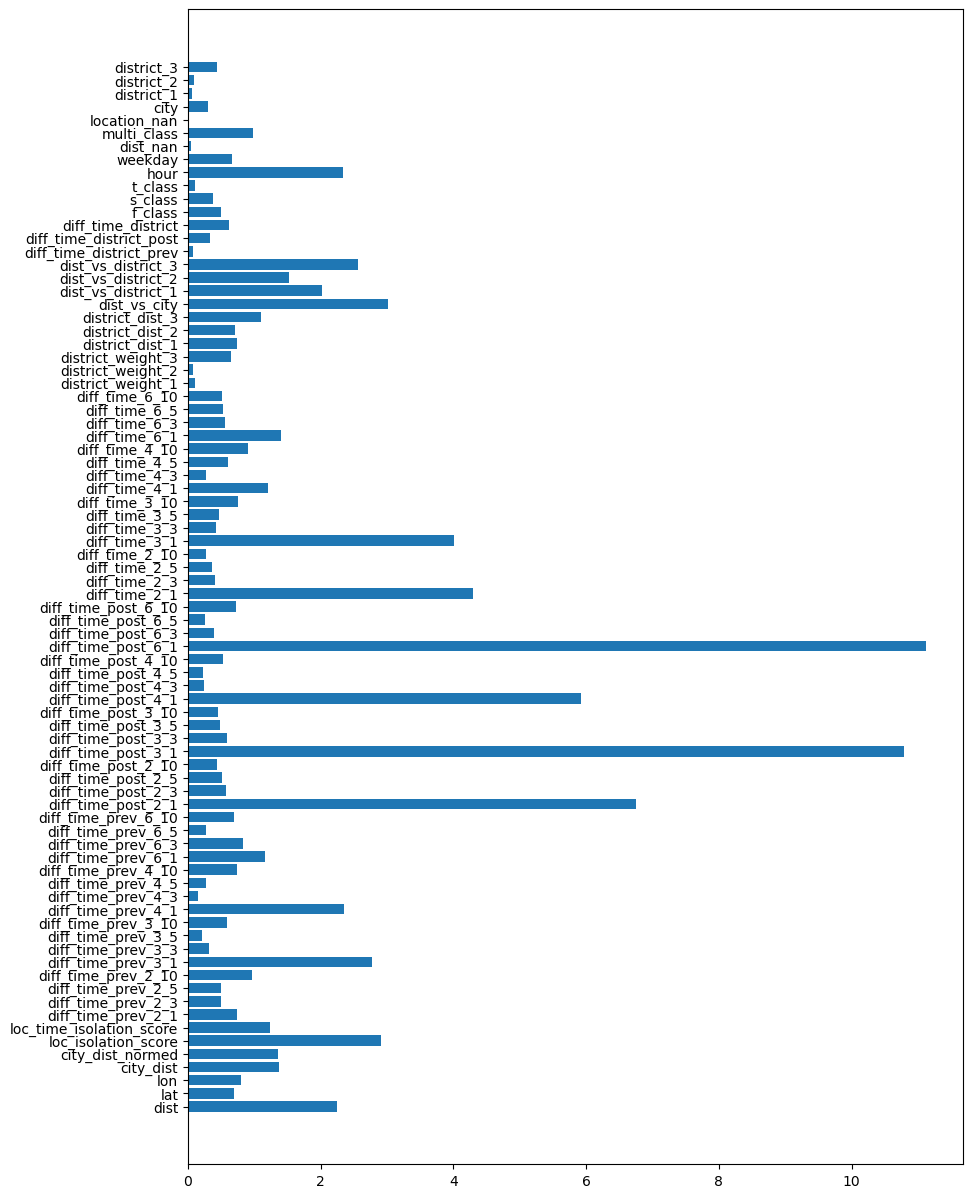

In [85]:
plt.figure(figsize=(10, 15))
plt.barh(y=X_train.columns, width=model.feature_importances_)
plt.show()

Можно заметить что брать фичи с периодом 1 выстреливают гораздо чаще, так что остальные скорее всего можно выкинуть  

In [86]:
model = CatBoostClassifier(
    cat_features=cat_features,
    task_type="GPU",
    devices='0:1',
    learning_rate=0.05
)
model.fit(
    X_train, 
    y_train, 
    verbose=False,
    eval_set=(X_test, y_test),
    use_best_model=True,

)

In [87]:
model.get_best_iteration()

998

In [88]:
y_pred = model.predict(X_test)
fbeta_score(y_test, y_pred, beta=beta)

0.6012073036884292

In [89]:
y_pred = model.predict_proba(X_test)[:, 1]
threshold = np.arange(0.1, 1, 0.01)
scores = []

for t in threshold:
    scores.append(fbeta_score(y_test, y_pred > t, beta=beta))

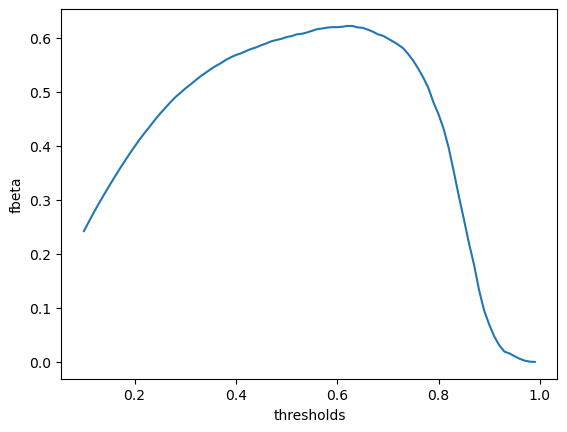

In [90]:
plt.plot(threshold, scores)
plt.ylabel('fbeta')
plt.xlabel('thresholds')
plt.show()

In [91]:
threshold[np.argmax(scores)], max(scores)

(0.6199999999999998, 0.6217803147882515)

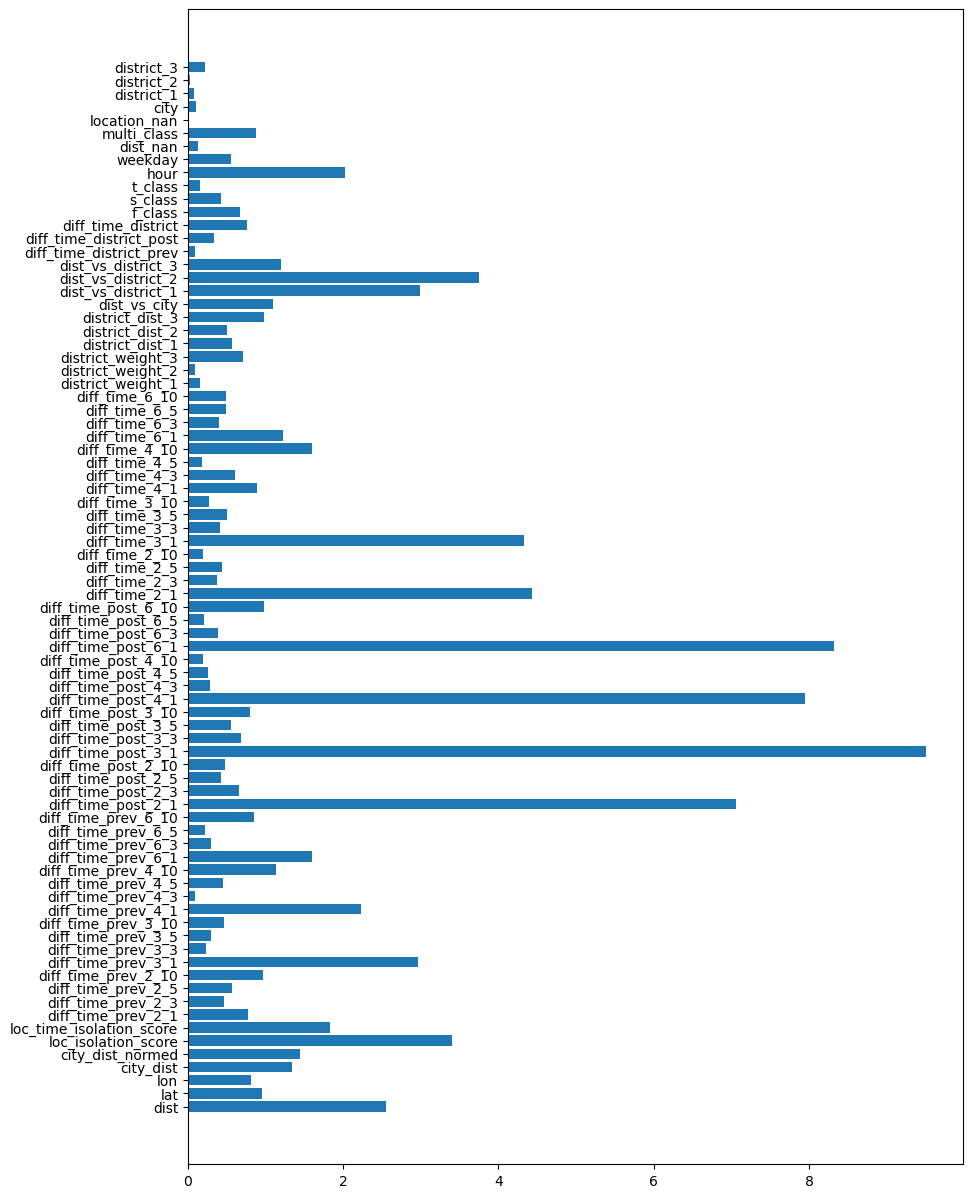

In [92]:
plt.figure(figsize=(10, 15))
plt.barh(y=X_train.columns, width=model.feature_importances_)
plt.show()

## Optuna

In [93]:
def objective_catboost_with_args(trial, X_train, y_train, X_test, y_test, cat_features):

    params = {
        'iterations': 900,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        'depth': 8,
        'task_type': 'GPU',
        'devices': '0:1',
        'cat_features': cat_features,
        'loss_function': 'Logloss'
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train, 
        y_train, 
        cat_features=cat_features,
        eval_set=(X_test, y_test),
        use_best_model=True,
        verbose=False,
    )

    y_pred = model.predict_proba(X_test)[:, 1]
    threshold = np.arange(0.1, 1, 0.01)
    scores = []

    for t in threshold:
        scores.append(fbeta_score(y_test, y_pred > t, beta=beta))

    return max(scores)

objective_catboost = partial(
    objective_catboost_with_args, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test,
    y_test=y_test,
    cat_features=cat_features
)

In [94]:
# gamma = lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 25)
# tpe_sampler = optuna.samplers.TPESampler(n_startup_trials=30, n_ei_candidates=24, gamma=gamma)

# study = optuna.create_study(
#     direction='maximize',
#     sampler=tpe_sampler,
#     pruner=None
# )

# study.optimize(
#     func=objective_catboost, 
#     n_trials=15,
#     timeout=None,
# )


In [96]:
# optuna.visualization.plot_slice(study)

In [97]:
def objective_catboost_with_args(trial, X_train, y_train, X_test, y_test, cat_features):

    params = {
        'iterations': 600,
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2),
        'depth': trial.suggest_int('depth', 5, 12),
        'l2_leaf_reg': trial.suggest_float('l2_reg', 0, 100),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS', 'Poisson', 'No']),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 1000),
        'auto_class_weights': trial.suggest_categorical('class_weights', [None, 'Balanced', 'SqrtBalanced']),
        'task_type': 'GPU',
        'devices': '0:1',
        'cat_features': cat_features,
    }

    model = CatBoostClassifier(**params)

    model.fit(
        X_train, 
        y_train, 
        cat_features=cat_features,
                eval_set=(X_test, y_test),
        use_best_model=True,
        verbose=False,
    )

    y_pred = model.predict_proba(X_test)[:, 1]
    threshold = np.arange(0.1, 1, 0.01)
    scores = []

    for t in threshold:
        scores.append(fbeta_score(y_test, y_pred > t, beta=beta))

    return max(scores)

objective_catboost = partial(
    objective_catboost_with_args, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test,
    y_test=y_test,
    cat_features=cat_features
)

In [98]:
# gamma = lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 25)
# tpe_sampler = optuna.samplers.TPESampler(n_startup_trials=30, n_ei_candidates=24, gamma=gamma)

# study = optuna.create_study(
#     direction='maximize',
#     sampler=tpe_sampler,
#     pruner=None
# )

# study.optimize(
#     func=objective_catboost, 
#     n_trials=60,
#     timeout=None,
# )

# LightGBM

In [99]:
from functools import partial
import lightgbm

In [100]:
X_train[cat_features] = X_train[cat_features].apply(lambda x: pd.factorize(x)[0])
X_test[cat_features] = X_test[cat_features].apply(lambda x: pd.factorize(x)[0])

In [101]:
# def my_custom_metric(y_true, y_pred):
#     score = max((fbeta_score(y_true, y_pred > t, beta=0.2) for t in y_pred))
#     return 'best_fbeta', score, True

In [180]:
from sklearn.metrics import precision_recall_curve
def calc_fbetas(prec, rec, beta):
    return (1 + beta ** 2) * prec * rec / (beta ** 2 * prec + rec)

def my_metrict(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    fbetas = calc_fbetas(precision, recall, 0.2)
    return 'my_fbeta', np.max(fbetas), True


In [189]:
lgb_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.13277136831256797,
    max_depth=10,
    reg_alpha=0.35420209056958263,
)

lgb_model.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test),
    eval_metric=my_metrict,
    early_stopping_rounds=100,
    verbose=False,
    categorical_feature=cat_features,
)

LGBMClassifier(learning_rate=0.13277136831256797, max_depth=10,
               n_estimators=300, reg_alpha=0.35420209056958263)

In [190]:
lgb_model.best_iteration_

39

In [191]:
y_pred = lgb_model.predict_proba(X_test)[:, 1]
my_metrict(y_test, y_pred)

('my_fbeta', 0.6049523980946381, True)

In [195]:
y_pred_tr = lgb_model.predict_proba(X_train)[:, 1]
my_metrict(y_test, y_pred)

('my_fbeta', 0.6049523980946381, True)

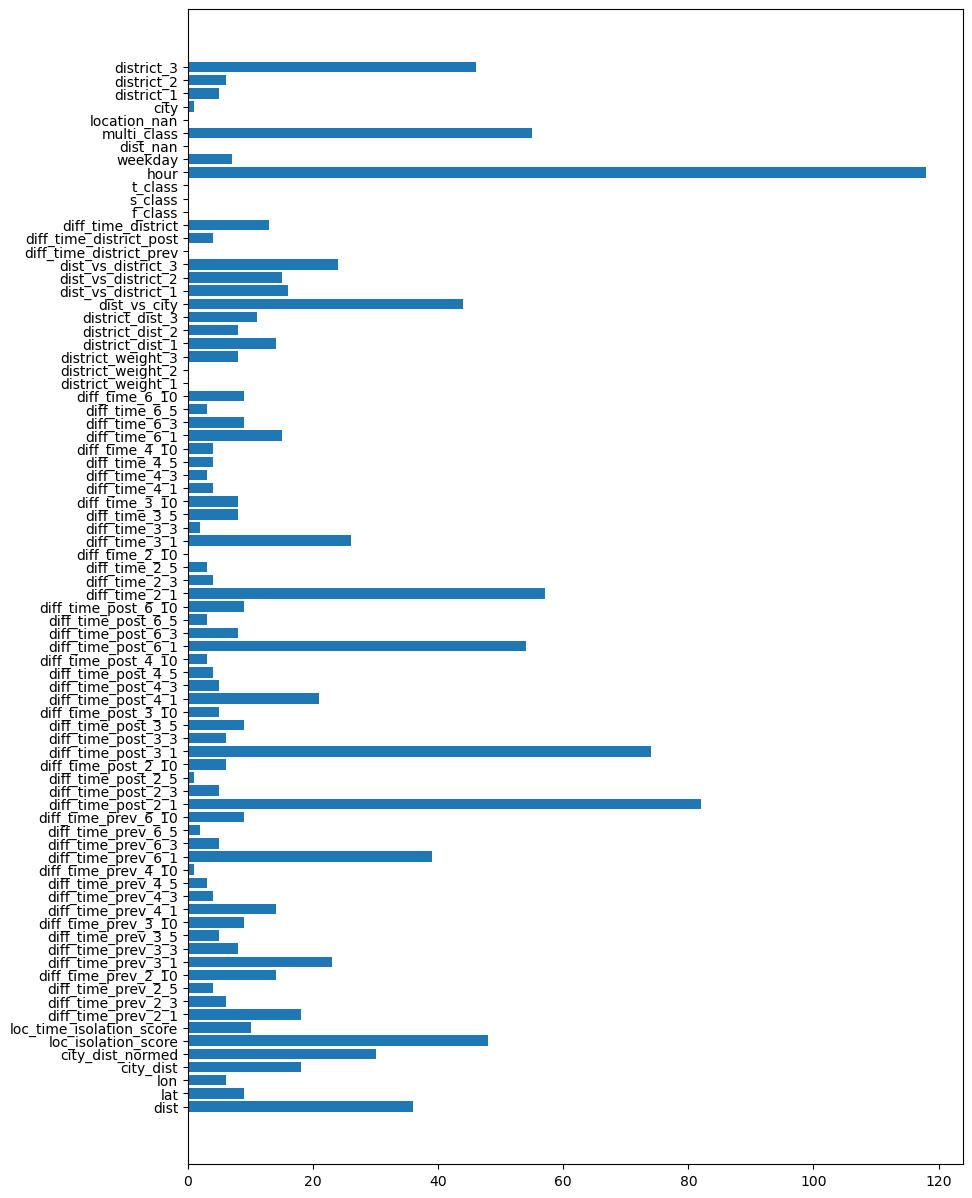

In [192]:
plt.figure(figsize=(10, 15))
plt.barh(y=X_train.columns, width=lgb_model.feature_importances_)
plt.show()

In [ ]:
X_train

In [213]:
# # plt.figure(figsize=(10, 10))
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# sns.histplot(x=y_pred, hue=y_test, ax=axs[0, 0], bins=30)
# axs[0, 0].set_title('test')
# axs[0, 0].set_yscale('log')

# sns.histplot(x=y_pred_tr, hue=y_train, ax=axs[0, 1], bins=30)
# axs[0, 1].set_title('train')
# axs[0, 1].set_yscale('log')

# plt.show()

from seminar_utils import plot_scores, plot_curves, get_shap

plot_scores(X_train, y_pred_tr, X_test, y_pred)
plot_curves(y_train, y_pred_tr, y_test, y_pred)
# get_shap(model, X_tr, 'is_callcenter', features)

SystemError: initialization of _internal failed without raising an exception

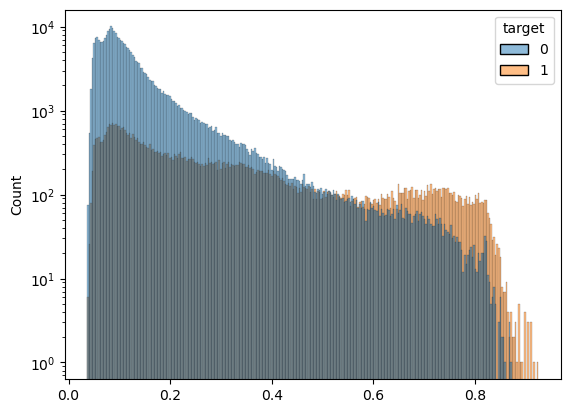

In [194]:
sns.histplot(x=y_pred, hue=y_test)
plt.yscale('log')
plt.show()

In [126]:
def objective_lgbm_with_args(trial, X_train, y_train, X_test, y_test, cat_features):

    params = {
        'n_estimators': 600,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5),
        # 'max_depth': trial.suggest_int(),
        'categorical_features': cat_features,
    }

    model = LGBMClassifier(**params)

    model.fit(
        X_train, 
        y_train, 
        eval_set=(X_test, y_test),
        early_stopping_rounds=100,
        verbose=False,
        categorical_feature=cat_features
    )

    y_pred = model.predict_proba(X_test)[:, 1]
    threshold = np.arange(0.1, 1, 0.01)
    scores = []

    for t in threshold:
        scores.append(fbeta_score(y_test, y_pred > t, beta=beta))

    return max(scores)

In [127]:
objective_lgbm = partial(
    objective_lgbm_with_args, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test,
    y_test=y_test,
    cat_features=cat_features
)
gamma = lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 25)
tpe_sampler = optuna.samplers.TPESampler(n_startup_trials=30, n_ei_candidates=24, gamma=gamma)

study = optuna.create_study(
    direction='maximize',
    sampler=tpe_sampler,
    pruner=None
)

study.optimize(
    func=objective_lgbm, 
    n_trials=50,
    timeout=None,
)

[I 2023-05-07 20:21:56,273] A new study created in memory with name: no-name-8b3ca69c-205e-41f3-80db-6fbbadc94042
c:\Users\justw\miniconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\justw\miniconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\justw\miniconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
c:\Us

In [128]:
optuna.visualization.plot_slice(study)

In [134]:
def objective_lgbm_with_args(trial, X_train, y_train, X_test, y_test, cat_features):

    has_max_depth = trial.suggest_categorical('has_max_depth', [True, False])

    params = {
        'n_estimators': 600,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15) if has_max_depth else -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss',]),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10_000, log=True),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'categorical_features': cat_features,
    }

    model = LGBMClassifier(**params)

    model.fit(
        X_train, 
        y_train, 
        eval_set=(X_test, y_test),
        early_stopping_rounds=100,
        verbose=False,
        categorical_feature=cat_features
    )

    y_pred = model.predict_proba(X_test)[:, 1] > 0.63
    # threshold = np.arange(0.1, 1, 0.01)
    # scores = []

    # for t in threshold:
    #     scores.append(fbeta_score(y_test, y_pred > t, beta=beta))

    return fbeta_score(y_test, y_pred, beta=beta)

In [135]:
import warnings
warnings.filterwarnings('ignore')

In [136]:
objective_lgbm = partial(
    objective_lgbm_with_args, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test,
    y_test=y_test,
    cat_features=cat_features
)
gamma = lambda n_trials: min(int(np.ceil(0.1 * n_trials)), 25)
tpe_sampler = optuna.samplers.TPESampler(n_startup_trials=30, n_ei_candidates=24, gamma=gamma)

study = optuna.create_study(
    direction='maximize',
    sampler=tpe_sampler,
    pruner=None
)

study.optimize(
    func=objective_lgbm, 
    n_trials=100,
    timeout=None,
)

[I 2023-05-07 21:10:00,023] A new study created in memory with name: no-name-3989a187-5881-4054-80ea-7b9b2db3690b
[I 2023-05-07 21:11:30,900] Trial 0 finished with value: 0.42074817782212476 and parameters: {'has_max_depth': True, 'learning_rate': 0.17410257144150246, 'depth': 10, 'boosting_type': 'dart', 'reg_alpha': 7640.771323124335, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.42074817782212476.
[I 2023-05-07 21:11:39,616] Trial 1 finished with value: 0.6057874576758657 and parameters: {'has_max_depth': True, 'learning_rate': 0.13935308407975436, 'depth': 15, 'boosting_type': 'gbdt', 'reg_alpha': 0.990142092254051, 'class_weight': None}. Best is trial 1 with value: 0.6057874576758657.
[I 2023-05-07 21:13:29,060] Trial 2 finished with value: 0.6089321751338072 and parameters: {'has_max_depth': False, 'learning_rate': 0.1249351026189751, 'boosting_type': 'dart', 'reg_alpha': 0.00410548838590949, 'class_weight': None}. Best is trial 2 with value: 0.6089321751338072.
[I 2

KeyboardInterrupt: 

In [166]:
optuna.visualization.plot_slice(study)

In [138]:
import dill
dill.dump_session('lgbm_optuned.db')

# Explore model

In [141]:
study.best_params

{'has_max_depth': True,
 'learning_rate': 0.13277136831256797,
 'depth': 10,
 'boosting_type': 'dart',
 'reg_alpha': 0.35420209056958263,
 'class_weight': None}

In [176]:
lgb_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.13277136831256797,
    max_depth=10,
    # boosting_type='dart',
    reg_alpha=0.35420209056958263,
)

# lightgbm.early_stopping(stopping_rounds=100)

lgb_model.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test),
    early_stopping_rounds=100,
    verbose=False,
    categorical_feature=cat_features,
)

lgb_model.best_iteration_

39

In [164]:
y_pred = lgb_model.predict_proba(X_test)[:, 1]

In [177]:
from sklearn.metrics import precision_recall_curve
def calc_fbetas(prec, rec, beta):
    return (1 + beta ** 2) * prec * rec / (beta ** 2 * prec + rec)

In [178]:
%%time
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fbetas = calc_fbetas(precision, recall, 0.2)

best_idx = np.argmax(fbetas)
best_thr = thresholds[best_idx]

CPU times: total: 125 ms
Wall time: 128 ms


In [179]:
best_thr, fbeta_score(y_test, y_pred > best_thr, beta=beta)

(0.6319049979090605, 0.6115132155324625)

# Predict

In [ ]:
predict = pd.read_csv('data/test.csv')
predict['index'] = predict.index

In [ ]:
train_data_trans = transformer.fit_transform(train_data)
predict_trans = transformer.transform(predict)

In [ ]:
X_train = train_data_trans[num_features + cat_features].copy()
X_train[cat_features] = X_train[cat_features].astype(str)
y_train = train_data_trans['target']

X_test = predict_trans[num_features + cat_features].copy()
X_test[cat_features] = X_test[cat_features].astype(str)

In [ ]:
model = CatBoostClassifier(cat_features=cat_features, iterations=500)
model.fit(X_train, y_train, verbose=False)

In [ ]:
t = 0.62
predict_trans['target'] = model.predict_proba(X_test)[:, 1] >= t

In [ ]:
predict_trans['target'].value_counts()

False    493933
True      17004
Name: target, dtype: int64

Подозрительно мало отмен

In [ ]:
predict_trans[['index', 'target']].to_csv('data/sub3.csv', index=False)